# Create and save dataset images


In order to save the overhead of processing all the images everytime I run the model - I decide to save the images in different directories (train, test, validaiton) where the data is also split into directories represinting their font.

First let's import all the necessary libraries:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import h5py
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

from numpy import asarray
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset consists of images cotaining different letters with one the following 7 fonts. We should convert every font to a categorical value - an integer represnting it.

In [ ]:
classes = [b'Raleway', b'Open Sans', b'Roboto', b'Ubuntu Mono', b'Michroma', b'Alex Brush', b'Russo One']

def convert_font_to_int(font):
  return classes.index(font)

# Show mapping
table = [[font, i] for i, font in enumerate(classes)]
print(tabulate(table, headers=["font", "number"]))

font           number
-----------  --------
Raleway             0
Open Sans           1
Roboto              2
Ubuntu Mono         3
Michroma            4
Alex Brush          5
Russo One           6


I will create a convolutional neural network which classifies for every letter in the image to one of the fonts. So after reading every image I will crop the letter (the coordinates are given in the dataset).
The following method saves the every cropped image:

In [ ]:
def crop_char(coordinates, image, folder, file_name, font):
  """ 
  Cropps character in an image 
  """
  # Crop image
  SIZE = 18
  pt_A, pt_D, pt_C, pt_B = coordinates.tolist()
  input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
  output_pts = np.float32([[0, 0], [0,SIZE - 1], [SIZE - 1, SIZE - 1], [SIZE - 1, 0]])
  M = cv2.getPerspectiveTransform(input_pts,output_pts)
  warped = cv2.warpPerspective(image,M,(SIZE, SIZE),flags=cv2.INTER_LINEAR)

  # Remove noise
  no_noise = cv2.fastNlMeansDenoisingColored(warped)

  # Save image
  pil_image = Image.fromarray(no_noise, 'RGB')
  pil_image.save(f"/content/drive/MyDrive/Project/{folder}/{font}/{file_name}.png")

The following method extracts the images of all the letters in the image:

In [ ]:
def extract_chars(image_name, folder):
  """ 
  Extracts char images from image 
  """
  charBB = np.asarray(db['data'][image_name].attrs['charBB']).transpose().astype(int)
  fonts = np.asarray(db['data'][image_name].attrs['font'])

  letters = []
  for word in db['data'][image_name].attrs['txt']:
    letters += list(word.decode('UTF-8'))

  image = db['data'][image_name][:]
  char_images = []
  for char, letter, font in zip(charBB, letters, fonts):
    try:
      char_images.append(crop_char(char, 
                        np.asarray(Image.fromarray(image).convert('RGB')),
                        folder, f"{image_name}_{letter}",
                        convert_font_to_int(font)))
    except Exception as e:
      print(f"skipped: {e}")
  return char_images

The dataset is stored in an h5 file which containt the images, the coordinates of the chars, the letters, the actual fonts and the text of each word. The following method splits all the images into 3 datasets: training set (80%), validation set (10%), and a testing set (10%):

In [ ]:
db = h5py.File("/content/drive/MyDrive/Project/SynthText.h5", 'r')
image_names = list(db['data'].keys())
train_set, test_set, valid_set = np.split(image_names, [int(.8 * len(image_names)), int(.9 * len(image_names))])
print(f"The dataset is split into a training set ({len(train_set)}), validation set ({len(valid_set)}), and a test set ({len(test_set)})")

The dataset is split into a training set (778), validation set (98), and a test set (97)


For every image the sub-images of the letters dispayed in it are saved in an appropriate location:

In [ ]:
# Save training set
for image_name in train_set:
  extract_chars(image_name, "enhanced/train")

# Save test set
for image_name in test_set:
  extract_chars(image_name, "enhanced/test")

# Save validation set
for image_name in valid_set:
  extract_chars(image_name, "enhanced/validation")

# Create and train a CNN

Before defining the model, let's first extract the images for the train, test, and validation sets:

In [ ]:
SIZE = (18, 18)
BATCH_SIZE = 32

train_set = image_dataset_from_directory(
    "/content/drive/MyDrive/Project/enhanced/train",
    image_size=SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

valid_set = image_dataset_from_directory(
    "/content/drive/MyDrive/Project/enhanced/validation",
    image_size=SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

test_set = image_dataset_from_directory(
    "/content/drive/MyDrive/Project/enhanced/test",
    image_size=SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

Found 18996 files belonging to 7 classes.
Found 2263 files belonging to 7 classes.
Found 2723 files belonging to 7 classes.
['0', '1', '2', '3', '4', '5', '6']


Let's create the model - a convolutional neural network for processing the char images:

In [ ]:
model = Sequential([
        Rescaling(1.0 / 255, input_shape=(18, 18, 3)),

        Conv2D(32, kernel_size=3, activation="relu", padding='same', strides=1),
        MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        Dropout(0.2),
     
        Conv2D(64, kernel_size=3, activation="relu", padding='same', strides=1),
        MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        Dropout(0.2),

        Conv2D(128, kernel_size=3, activation="relu", padding='same', strides=1),
        MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        Dropout(0.2),
     
        Flatten(),
        Dense(100, activation='relu'),
        Dense(7, activation="softmax"),
    ])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Now, let's train the model on the train set, using the validaiton set to see the generalization of the model:

Epoch 1/30
594/594 [==============================] - 15s 24ms/step - loss: 1.7919 - accuracy: 0.2535 - val_loss: 1.4364 - val_accuracy: 0.4224
Epoch 2/30
594/594 [==============================] - 13s 22ms/step - loss: 1.2987 - accuracy: 0.4910 - val_loss: 1.2239 - val_accuracy: 0.5373
Epoch 3/30
594/594 [==============================] - 12s 20ms/step - loss: 1.1470 - accuracy: 0.5569 - val_loss: 1.1466 - val_accuracy: 0.5762
Epoch 4/30
594/594 [==============================] - 14s 24ms/step - loss: 1.0511 - accuracy: 0.6019 - val_loss: 1.0835 - val_accuracy: 0.6014
Epoch 5/30
594/594 [==============================] - 13s 22ms/step - loss: 0.9844 - accuracy: 0.6257 - val_loss: 1.0303 - val_accuracy: 0.6116
Epoch 6/30
594/594 [==============================] - 13s 22ms/step - loss: 0.9290 - accuracy: 0.6468 - val_loss: 0.9999 - val_accuracy: 0.6253
Epoch 7/30
594/594 [==============================] - 13s 22ms/step - loss: 0.8888 - accuracy: 0.6612 - val_loss: 0.9814 - val_accuracy:

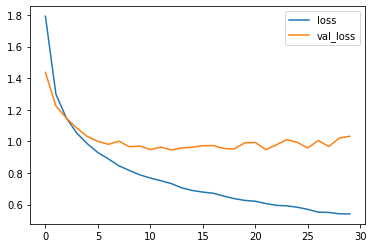

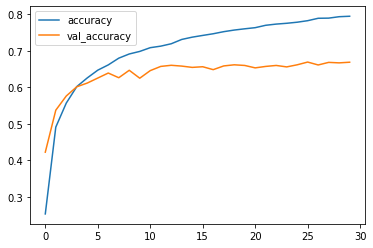

In [ ]:
# Train
history = model.fit(
    train_set,
    epochs=30, 
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data=valid_set,
    use_multiprocessing=True,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

Finally, let's evaluate the model on the testing set and save its weights

In [ ]:
# Evaluate model
model.evaluate(test_set, verbose=1)
print(test_set.class_names)

# Save the model
model.save_weights("/content/drive/MyDrive/Project/model_weights.ckpt")

86/86 [==============================] - 1s 12ms/step - loss: 0.7465 - accuracy: 0.7319
['0', '1', '2', '3', '4', '5', '6']
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_32 (Rescaling)    (None, 18, 18, 3)         0         
                                                                 
 conv2d_126 (Conv2D)         (None, 18, 18, 32)        896       
                                                                 
 max_pooling2d_122 (MaxPooli  (None, 9, 9, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_136 (Dropout)       (None, 9, 9, 32)          0         
                                                                 
 conv2d_127 (Conv2D)         (None, 9, 9, 64)          18496     
                                                             